**Sistema de Reconhecimento facial ao vivo em tempo real.**

**Projeto Final:** EY Fast Track Specialist - Machine Learning

Este projeto foi construido usando a rede de reconhecimento facial do python dlib e APIs face_recognition (do OpenCV). Dlib é uma biblioteca de software de uso geral.

Implementamos este projeto python em duas partes:

1. Na primeira parte, armazenamos as informações sobre a estrutura da face humana, ou seja, a incorporação da face. Em seguida, armazenamos esses embeddings.

2. Na segunda parte, reconhecer a pessoa comparando os novos rostos incorporados com os armazenados.

Link Colab: https://colab.research.google.com/drive/1sVDr4i1qC_GJGP9Yi3FGpFt_2cHqj5zx?usp=sharing

Robson de Abreu Parreiras

Instalando os pacotes

In [2]:
!pip3 install dlib 
!pip3 install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Nesta etapa, capturamos imagens da pessoa e faremos os embeddings de rosto dessas imagens.

Importando as bibliotecas necessárias



> *Se ocorrer erro para importar a face_recognition, vá para Runtime -> Change 
Runtime -> Select GPU*



In [3]:
import sys
import face_recognition
import cv2 
import pickle
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from PIL import Image as Img
import numpy as np
import glob

Para identificar a pessoa em um arquivo pickle, pegue seu nome e um id exclusivo como entrada:

In [4]:
name=input("Digite seu nome: ")
ref_id=input("Digite seu id: ")

Digite seu nome: Robson
Digite seu id: 001


Crie um arquivo pickle e um dicionário para armazenar codificações de rosto:

In [5]:
try:
    f=open("ref_name.pkl","rb")
    ref_dictt=pickle.load(f)
    f.close()
except:
    ref_dictt={}
ref_dictt[ref_id]=name
f=open("ref_name.pkl","wb")
pickle.dump(ref_dictt,f)
f.close()
try:
    f=open("ref_embed.pkl","rb")
    embed_dictt=pickle.load(f)
    f.close()
except:
    embed_dictt={}

Função para habilitar a webcam

In [6]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


Abra a webcam e tire 5 fotos de uma pessoa e crie seus embeddings:


<IPython.core.display.Javascript object>

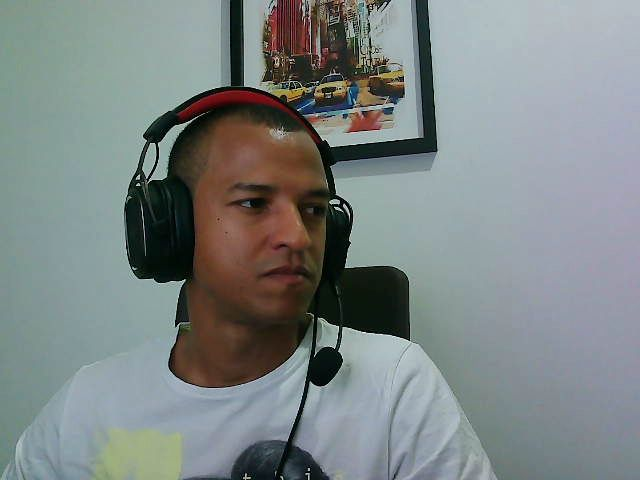

In [8]:
#for i in range(1):
key = cv2. waitKey(1)
webcam = take_photo()
    #webcam = cv2.VideoCapture(0)
    #while True:
        #check, frame = webcam.read()
frame = cv2.imread(webcam)
cv2_imshow(frame)
small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
rgb_small_frame = small_frame[:, :, ::-1]
  
key = cv2.waitKey(1)
  #if key == ord('s') : 
face_locations = face_recognition.face_locations(rgb_small_frame)
if face_locations != []:
  face_encoding = face_recognition.face_encodings(frame)[0]
  if ref_id in embed_dictt:
    embed_dictt[ref_id]+=[face_encoding]
  else:
    embed_dictt[ref_id]=[face_encoding]
#webcam.release()
cv2.waitKey(1)
cv2.destroyAllWindows()     
#break
        #elif key == ord('q'):
            #print("Desligando a camera.")
            #webcam.release()
            #print("Camera off.")
            #print("Programa finalizado.")
            #cv2.destroyAllWindows()
            #break

Aqui nós armazenamos o embed_dictt em um arquivo pickle. Portanto, para reconhecer essa pessoa no futuro, podemos carregar diretamente seus embeddings a partir deste arquivo

In [9]:
f=open("ref_embed.pkl","wb")
pickle.dump(embed_dictt,f)
f.close()

Carregue os arquivos de picles armazenados

In [10]:
f=open("ref_name.pkl","rb")
ref_dictt=pickle.load(f)        
f.close()
f=open("ref_embed.pkl","rb")
embed_dictt=pickle.load(f)      
f.close()

Crie duas listas, uma para armazenar ref_id e outra para a respectiva incorporação

In [11]:
known_face_encodings = []  
known_face_names = []  
for ref_id , embed_list in embed_dictt.items():
    for my_embed in embed_list:
        known_face_encodings +=[my_embed]
        known_face_names += [ref_id]

Inicie a webcam para reconhecer a pessoa

<IPython.core.display.Javascript object>

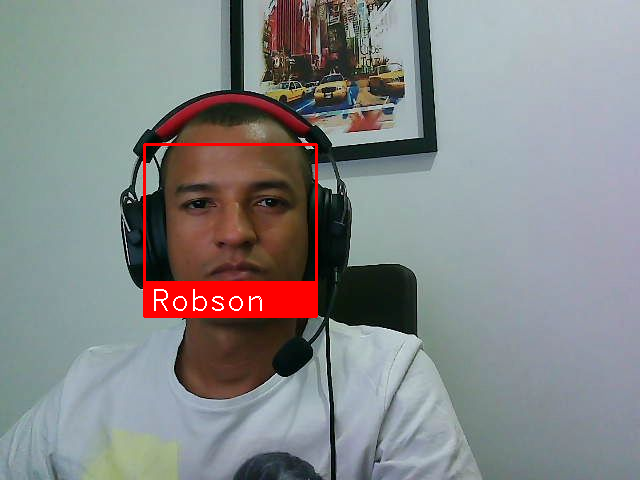

In [12]:
video_capture = take_photo()
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True
#while True  :
  
frame = cv2.imread(video_capture)
small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
rgb_small_frame = small_frame[:, :, ::-1]
if process_this_frame:
  face_locations = face_recognition.face_locations(rgb_small_frame)
  face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
  face_names = []
  for face_encoding in face_encodings:
      matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
      name = "Unknown"
      face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
      best_match_index = np.argmin(face_distances)
      if matches[best_match_index]:
           name = known_face_names[best_match_index]
           face_names.append(name)
      process_this_frame = not process_this_frame
      for (top_s, right, bottom, left), name in zip(face_locations, face_names):
        top_s *= 4
        right *= 4
        bottom *= 4
        left *= 4
        cv2.rectangle(frame, (left, top_s), (right, bottom), (0, 0, 255), 2)
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, ref_dictt[name], (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
      font = cv2.FONT_HERSHEY_DUPLEX
      cv2_imshow(frame)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
       #break 
#video_capture.release()
cv2.destroyAllWindows()